In [1]:
path = ''

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import re
import nltk
from nltk.tokenize import word_tokenize as wt 
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
from torch.optim import Adam
torch.cuda.empty_cache()

# Datasets

In [3]:
#train set
X_train = np.array(open(path+'Train/seq.in').read().split('\n')[:-1])
y_train = np.array(open(path+'Train/label').read().split('\n')[:-1])
df_train = pd.DataFrame({'query':X_train, 'category':y_train})

#test set
X_test = np.array(open(path+'test/seq.in').read().split('\n')[:-1])
y_test_ = np.array(open(path+'test/label').read().split('\n')[:-1])
df_test = pd.DataFrame({'query':X_test, 'category':y_test_})

#labels
labels_list = open(path+'intent_label.txt','r').read().split('\n')[:-1]
labels = dict(zip(labels_list,range(len(labels_list))))

In [4]:
labels

{'UNK': 0,
 'atis_abbreviation': 1,
 'atis_aircraft': 2,
 'atis_aircraft#atis_flight#atis_flight_no': 3,
 'atis_airfare': 4,
 'atis_airline': 5,
 'atis_airline#atis_flight_no': 6,
 'atis_airport': 7,
 'atis_capacity': 8,
 'atis_cheapest': 9,
 'atis_city': 10,
 'atis_distance': 11,
 'atis_flight': 12,
 'atis_flight#atis_airfare': 13,
 'atis_flight_no': 14,
 'atis_flight_time': 15,
 'atis_ground_fare': 16,
 'atis_ground_service': 17,
 'atis_ground_service#atis_ground_fare': 18,
 'atis_meal': 19,
 'atis_quantity': 20,
 'atis_restriction': 21}

In [5]:
#check Categories:
print('unkown categories in testset:')
for cat in df_test['category'].unique():
    if cat not in labels_list:
        print(cat)

print()
print('unkown categories in trainset:')
for cat in df_train['category'].unique():
    if cat not in labels_list:
        print(cat)

unkown categories in testset:
atis_day_name
atis_airfare#atis_flight
atis_flight#atis_airline
atis_flight_no#atis_airline

unkown categories in trainset:


In [6]:
df_train['category'].value_counts()

atis_flight                                 3309
atis_airfare                                 385
atis_ground_service                          230
atis_airline                                 139
atis_abbreviation                            130
atis_aircraft                                 70
atis_flight_time                              45
atis_quantity                                 41
atis_flight#atis_airfare                      19
atis_city                                     18
atis_airport                                  17
atis_distance                                 17
atis_capacity                                 15
atis_ground_fare                              15
atis_flight_no                                12
atis_meal                                      6
atis_restriction                               5
atis_airline#atis_flight_no                    2
atis_aircraft#atis_flight#atis_flight_no       1
atis_ground_service#atis_ground_fare           1
atis_cheapest       

In [19]:
#the minimum accuracy we need
(df_train['category']=='atis_flight').sum()/len(df_train)

0.7389459580169718

In [7]:
df_test['category'].value_counts()

atis_flight                    632
atis_airfare                    48
atis_airline                    38
atis_ground_service             36
atis_abbreviation               33
atis_capacity                   21
atis_airport                    18
atis_flight#atis_airfare        12
atis_distance                   10
atis_aircraft                    9
atis_flight_no                   8
atis_ground_fare                 7
atis_city                        6
atis_meal                        6
atis_quantity                    3
atis_day_name                    2
atis_flight_time                 1
atis_flight_no#atis_airline      1
atis_airfare#atis_flight         1
atis_flight#atis_airline         1
Name: category, dtype: int64

In [8]:
#Unknown Categories are only in test set so we can count them as UNK.
#correct categories:
df_test['category'] = df_test['category'].apply(lambda x: 'atis_flight#atis_airfare' if x=='atis_airfare#atis_flight'
                                               else 'atis_airline#atis_flight_no' if x=='atis_flight_no#atis_airline'
                                               else 'UNK' if x=='atis_day_name' or x=='atis_flight#atis_airline'
                                               else x)

#give a numeric label
df_train['label'] = [labels[label] for label in df_train['category']]
df_test['label'] = [labels[label] for label in df_test['category']]

#split to train and validation
X_tr, X_va, y_tr, y_va = train_test_split(df_train['query'], df_train['label'], test_size=0.2, random_state=42)

y_test = np.array(df_test['label'])


# Intent Classification with Bag-of-words

In [9]:
nltk.download('punkt',quiet=True)
nltk.download('stopwords', quiet=True)
stemmer = PorterStemmer()

# Converting free text to clean and standard text
def tokenizing(text):
    # remove non alphabatic characters
    text = re.sub('[^A-Za-z]', ' ', text)
    
    # tokenizing
    tokenized_text = wt(text)

    # remove stop words and stemming
    text_cleared = []
    for word in tokenized_text:
        if word not in set(stopwords.words('english')):
            text_cleared.append(stemmer.stem(word))

    text = " ".join(text_cleared)
    return text
    

In [10]:
# creating the feature matrix 
fea_matrix = CountVectorizer(max_features=1000)

#traning set
X_train_tok = X_tr.apply(tokenizing) #cleaning text
X_train_tok = fea_matrix.fit_transform(X_train_tok).toarray() #fitting and convering to a vector.

#validation
X_valid_tok = X_va.apply(tokenizing)
X_valid_tok = fea_matrix.transform(X_valid_tok).toarray() #converting to a vector with the same dimensions

#test
X_test_tok = df_test['query'].apply(tokenizing)
X_test_tok = fea_matrix.transform(X_test_tok).toarray()


In [11]:
#check dimensions
print(X_train_tok.shape)
print(X_valid_tok.shape)
print(X_test_tok.shape)

(3582, 459)
(896, 459)
(893, 459)


In [12]:
#dataset prepare
class BagDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


In [13]:
# NN for classifing 
class Bag_of_Classifier(nn.Module):
    def __init__(self, num_feature, num_class):
        super(Bag_of_Classifier, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [14]:
def train_bag(model, train_data, val_data, learning_rate, epochs, batch_size):
    
    #trainset
    X_train = torch.FloatTensor(train_data[0]) 
    train_dataset = BagDataset(X_train, torch.from_numpy(np.array(train_data[1])).long())
    train_dataloader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  shuffle=True)

    #validation set
    X_valid = torch.FloatTensor(val_data[0]) 
    val_dataset = BagDataset(X_valid, torch.from_numpy(np.array(val_data[1])).long())
    val_dataloader = DataLoader(dataset=val_dataset,
                                  batch_size=1)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    for e in tqdm(range(1, epochs+1)):
        # TRAINING
        
        model.train()
        total_acc_train = 0
        total_loss_train = 0
    
        for train_input, train_label in train_dataloader:
            optimizer.zero_grad()
            output = model(train_input)

            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()

            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

        # VALIDATION    
        total_acc_val = 0
        total_loss_val = 0
        
        with torch.no_grad():
            model.eval()
            for val_input, val_label in val_dataloader:
                output = model(val_input)
                
                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()

                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc

        loss_stats['train'].append(total_loss_train/len(train_data[1]))
        accuracy_stats['train'].append(total_acc_train/len(train_data[1]))
        loss_stats['val'].append(total_loss_val/len(val_data[1]))
        accuracy_stats['val'].append(total_acc_val/len(val_data[1]))
        
        print(
        f'Epoch: {e} | Train Loss: {total_loss_train / len(train_data[1]): .3f} \
        | Train Accuracy: {total_acc_train / len(train_data[1]): .3f} \
        | Val Loss: {total_loss_val / len(val_data[1]): .3f} \
        | Val Accuracy: {total_acc_val / len(val_data[1]): .3f}')
    
    

In [15]:
batch_size = 16
LR = 1e-4
epochs = 100

model = Bag_of_Classifier(num_feature=X_train_tok.shape[1], num_class=len(labels_list))

accuracy_stats = {
    'train': [],
    "val": [] }
loss_stats = {
    'train': [],
    "val": [] }

train_bag(model, [X_train_tok, y_tr], [X_valid_tok,y_va],LR, epochs,batch_size)

  1%|          | 1/100 [00:00<01:30,  1.09it/s]

Epoch: 1 | Train Loss:  0.190         | Train Accuracy:  0.123         | Val Loss:  2.497         | Val Accuracy:  0.713


  2%|▏         | 2/100 [00:01<01:29,  1.10it/s]

Epoch: 2 | Train Loss:  0.137         | Train Accuracy:  0.559         | Val Loss:  1.885         | Val Accuracy:  0.853


  3%|▎         | 3/100 [00:02<01:27,  1.10it/s]

Epoch: 3 | Train Loss:  0.101         | Train Accuracy:  0.766         | Val Loss:  1.384         | Val Accuracy:  0.878


  4%|▍         | 4/100 [00:03<01:28,  1.08it/s]

Epoch: 4 | Train Loss:  0.076         | Train Accuracy:  0.826         | Val Loss:  1.014         | Val Accuracy:  0.895


  5%|▌         | 5/100 [00:04<01:26,  1.09it/s]

Epoch: 5 | Train Loss:  0.061         | Train Accuracy:  0.844         | Val Loss:  0.833         | Val Accuracy:  0.895


  6%|▌         | 6/100 [00:05<01:25,  1.10it/s]

Epoch: 6 | Train Loss:  0.051         | Train Accuracy:  0.870         | Val Loss:  0.684         | Val Accuracy:  0.907


  7%|▋         | 7/100 [00:06<01:24,  1.10it/s]

Epoch: 7 | Train Loss:  0.045         | Train Accuracy:  0.867         | Val Loss:  0.570         | Val Accuracy:  0.915


  8%|▊         | 8/100 [00:07<01:23,  1.11it/s]

Epoch: 8 | Train Loss:  0.039         | Train Accuracy:  0.882         | Val Loss:  0.509         | Val Accuracy:  0.913


  9%|▉         | 9/100 [00:08<01:21,  1.11it/s]

Epoch: 9 | Train Loss:  0.036         | Train Accuracy:  0.883         | Val Loss:  0.461         | Val Accuracy:  0.917


 10%|█         | 10/100 [00:09<01:20,  1.11it/s]

Epoch: 10 | Train Loss:  0.032         | Train Accuracy:  0.896         | Val Loss:  0.377         | Val Accuracy:  0.922


 11%|█         | 11/100 [00:09<01:20,  1.11it/s]

Epoch: 11 | Train Loss:  0.031         | Train Accuracy:  0.894         | Val Loss:  0.338         | Val Accuracy:  0.924


 12%|█▏        | 12/100 [00:10<01:19,  1.11it/s]

Epoch: 12 | Train Loss:  0.028         | Train Accuracy:  0.901         | Val Loss:  0.315         | Val Accuracy:  0.930


 13%|█▎        | 13/100 [00:11<01:19,  1.10it/s]

Epoch: 13 | Train Loss:  0.027         | Train Accuracy:  0.900         | Val Loss:  0.291         | Val Accuracy:  0.932


 14%|█▍        | 14/100 [00:12<01:18,  1.10it/s]

Epoch: 14 | Train Loss:  0.025         | Train Accuracy:  0.905         | Val Loss:  0.283         | Val Accuracy:  0.934


 15%|█▌        | 15/100 [00:13<01:16,  1.10it/s]

Epoch: 15 | Train Loss:  0.025         | Train Accuracy:  0.909         | Val Loss:  0.272         | Val Accuracy:  0.943


 16%|█▌        | 16/100 [00:14<01:15,  1.11it/s]

Epoch: 16 | Train Loss:  0.023         | Train Accuracy:  0.914         | Val Loss:  0.247         | Val Accuracy:  0.949


 17%|█▋        | 17/100 [00:15<01:14,  1.11it/s]

Epoch: 17 | Train Loss:  0.021         | Train Accuracy:  0.917         | Val Loss:  0.231         | Val Accuracy:  0.953


 18%|█▊        | 18/100 [00:16<01:13,  1.11it/s]

Epoch: 18 | Train Loss:  0.021         | Train Accuracy:  0.922         | Val Loss:  0.224         | Val Accuracy:  0.951


 19%|█▉        | 19/100 [00:17<01:13,  1.11it/s]

Epoch: 19 | Train Loss:  0.021         | Train Accuracy:  0.924         | Val Loss:  0.211         | Val Accuracy:  0.948


 20%|██        | 20/100 [00:18<01:12,  1.11it/s]

Epoch: 20 | Train Loss:  0.019         | Train Accuracy:  0.924         | Val Loss:  0.204         | Val Accuracy:  0.953


 21%|██        | 21/100 [00:19<01:12,  1.09it/s]

Epoch: 21 | Train Loss:  0.018         | Train Accuracy:  0.930         | Val Loss:  0.199         | Val Accuracy:  0.953


 22%|██▏       | 22/100 [00:19<01:12,  1.08it/s]

Epoch: 22 | Train Loss:  0.018         | Train Accuracy:  0.929         | Val Loss:  0.199         | Val Accuracy:  0.954


 23%|██▎       | 23/100 [00:20<01:10,  1.09it/s]

Epoch: 23 | Train Loss:  0.017         | Train Accuracy:  0.933         | Val Loss:  0.190         | Val Accuracy:  0.952


 24%|██▍       | 24/100 [00:21<01:08,  1.10it/s]

Epoch: 24 | Train Loss:  0.016         | Train Accuracy:  0.939         | Val Loss:  0.191         | Val Accuracy:  0.953


 25%|██▌       | 25/100 [00:22<01:07,  1.11it/s]

Epoch: 25 | Train Loss:  0.016         | Train Accuracy:  0.939         | Val Loss:  0.180         | Val Accuracy:  0.955


 26%|██▌       | 26/100 [00:23<01:06,  1.12it/s]

Epoch: 26 | Train Loss:  0.016         | Train Accuracy:  0.938         | Val Loss:  0.178         | Val Accuracy:  0.955


 27%|██▋       | 27/100 [00:24<01:05,  1.12it/s]

Epoch: 27 | Train Loss:  0.014         | Train Accuracy:  0.942         | Val Loss:  0.176         | Val Accuracy:  0.955


 28%|██▊       | 28/100 [00:25<01:04,  1.12it/s]

Epoch: 28 | Train Loss:  0.014         | Train Accuracy:  0.942         | Val Loss:  0.171         | Val Accuracy:  0.954


 29%|██▉       | 29/100 [00:26<01:03,  1.12it/s]

Epoch: 29 | Train Loss:  0.013         | Train Accuracy:  0.951         | Val Loss:  0.175         | Val Accuracy:  0.953


 30%|███       | 30/100 [00:27<01:02,  1.12it/s]

Epoch: 30 | Train Loss:  0.013         | Train Accuracy:  0.946         | Val Loss:  0.171         | Val Accuracy:  0.955


 31%|███       | 31/100 [00:27<01:01,  1.12it/s]

Epoch: 31 | Train Loss:  0.012         | Train Accuracy:  0.949         | Val Loss:  0.170         | Val Accuracy:  0.958


 32%|███▏      | 32/100 [00:28<01:00,  1.12it/s]

Epoch: 32 | Train Loss:  0.012         | Train Accuracy:  0.952         | Val Loss:  0.171         | Val Accuracy:  0.960


 33%|███▎      | 33/100 [00:29<00:59,  1.12it/s]

Epoch: 33 | Train Loss:  0.012         | Train Accuracy:  0.953         | Val Loss:  0.165         | Val Accuracy:  0.956


 34%|███▍      | 34/100 [00:30<00:59,  1.11it/s]

Epoch: 34 | Train Loss:  0.011         | Train Accuracy:  0.955         | Val Loss:  0.166         | Val Accuracy:  0.960


 35%|███▌      | 35/100 [00:31<00:58,  1.11it/s]

Epoch: 35 | Train Loss:  0.011         | Train Accuracy:  0.957         | Val Loss:  0.162         | Val Accuracy:  0.954


 36%|███▌      | 36/100 [00:32<00:57,  1.11it/s]

Epoch: 36 | Train Loss:  0.011         | Train Accuracy:  0.951         | Val Loss:  0.167         | Val Accuracy:  0.958


 37%|███▋      | 37/100 [00:33<00:56,  1.11it/s]

Epoch: 37 | Train Loss:  0.011         | Train Accuracy:  0.953         | Val Loss:  0.158         | Val Accuracy:  0.956


 38%|███▊      | 38/100 [00:34<00:55,  1.11it/s]

Epoch: 38 | Train Loss:  0.010         | Train Accuracy:  0.956         | Val Loss:  0.159         | Val Accuracy:  0.959


 39%|███▉      | 39/100 [00:35<00:54,  1.11it/s]

Epoch: 39 | Train Loss:  0.011         | Train Accuracy:  0.955         | Val Loss:  0.153         | Val Accuracy:  0.961


 40%|████      | 40/100 [00:36<00:53,  1.12it/s]

Epoch: 40 | Train Loss:  0.010         | Train Accuracy:  0.957         | Val Loss:  0.164         | Val Accuracy:  0.958


 41%|████      | 41/100 [00:36<00:52,  1.12it/s]

Epoch: 41 | Train Loss:  0.010         | Train Accuracy:  0.960         | Val Loss:  0.147         | Val Accuracy:  0.959


 42%|████▏     | 42/100 [00:37<00:51,  1.12it/s]

Epoch: 42 | Train Loss:  0.010         | Train Accuracy:  0.959         | Val Loss:  0.158         | Val Accuracy:  0.960


 43%|████▎     | 43/100 [00:38<00:50,  1.13it/s]

Epoch: 43 | Train Loss:  0.009         | Train Accuracy:  0.961         | Val Loss:  0.158         | Val Accuracy:  0.960


 44%|████▍     | 44/100 [00:39<00:49,  1.13it/s]

Epoch: 44 | Train Loss:  0.009         | Train Accuracy:  0.963         | Val Loss:  0.152         | Val Accuracy:  0.961


 45%|████▌     | 45/100 [00:40<00:48,  1.13it/s]

Epoch: 45 | Train Loss:  0.009         | Train Accuracy:  0.965         | Val Loss:  0.145         | Val Accuracy:  0.962


 46%|████▌     | 46/100 [00:41<00:47,  1.13it/s]

Epoch: 46 | Train Loss:  0.008         | Train Accuracy:  0.963         | Val Loss:  0.155         | Val Accuracy:  0.959


 47%|████▋     | 47/100 [00:42<00:46,  1.13it/s]

Epoch: 47 | Train Loss:  0.009         | Train Accuracy:  0.959         | Val Loss:  0.144         | Val Accuracy:  0.963


 48%|████▊     | 48/100 [00:43<00:46,  1.13it/s]

Epoch: 48 | Train Loss:  0.008         | Train Accuracy:  0.963         | Val Loss:  0.145         | Val Accuracy:  0.960


 49%|████▉     | 49/100 [00:44<00:45,  1.13it/s]

Epoch: 49 | Train Loss:  0.008         | Train Accuracy:  0.965         | Val Loss:  0.142         | Val Accuracy:  0.963


 50%|█████     | 50/100 [00:44<00:44,  1.13it/s]

Epoch: 50 | Train Loss:  0.008         | Train Accuracy:  0.966         | Val Loss:  0.147         | Val Accuracy:  0.963


 51%|█████     | 51/100 [00:45<00:43,  1.13it/s]

Epoch: 51 | Train Loss:  0.008         | Train Accuracy:  0.966         | Val Loss:  0.150         | Val Accuracy:  0.961


 52%|█████▏    | 52/100 [00:46<00:42,  1.13it/s]

Epoch: 52 | Train Loss:  0.007         | Train Accuracy:  0.969         | Val Loss:  0.148         | Val Accuracy:  0.962


 53%|█████▎    | 53/100 [00:47<00:41,  1.13it/s]

Epoch: 53 | Train Loss:  0.007         | Train Accuracy:  0.969         | Val Loss:  0.147         | Val Accuracy:  0.962


 54%|█████▍    | 54/100 [00:48<00:40,  1.13it/s]

Epoch: 54 | Train Loss:  0.007         | Train Accuracy:  0.968         | Val Loss:  0.155         | Val Accuracy:  0.960


 55%|█████▌    | 55/100 [00:49<00:39,  1.13it/s]

Epoch: 55 | Train Loss:  0.007         | Train Accuracy:  0.969         | Val Loss:  0.159         | Val Accuracy:  0.961


 56%|█████▌    | 56/100 [00:50<00:38,  1.13it/s]

Epoch: 56 | Train Loss:  0.007         | Train Accuracy:  0.967         | Val Loss:  0.150         | Val Accuracy:  0.963


 57%|█████▋    | 57/100 [00:51<00:38,  1.13it/s]

Epoch: 57 | Train Loss:  0.007         | Train Accuracy:  0.968         | Val Loss:  0.152         | Val Accuracy:  0.962


 58%|█████▊    | 58/100 [00:51<00:37,  1.13it/s]

Epoch: 58 | Train Loss:  0.007         | Train Accuracy:  0.970         | Val Loss:  0.152         | Val Accuracy:  0.963


 59%|█████▉    | 59/100 [00:52<00:36,  1.13it/s]

Epoch: 59 | Train Loss:  0.007         | Train Accuracy:  0.971         | Val Loss:  0.158         | Val Accuracy:  0.963


 60%|██████    | 60/100 [00:53<00:35,  1.13it/s]

Epoch: 60 | Train Loss:  0.007         | Train Accuracy:  0.971         | Val Loss:  0.156         | Val Accuracy:  0.963


 61%|██████    | 61/100 [00:54<00:34,  1.13it/s]

Epoch: 61 | Train Loss:  0.006         | Train Accuracy:  0.975         | Val Loss:  0.157         | Val Accuracy:  0.958


 62%|██████▏   | 62/100 [00:55<00:33,  1.13it/s]

Epoch: 62 | Train Loss:  0.007         | Train Accuracy:  0.975         | Val Loss:  0.164         | Val Accuracy:  0.961


 63%|██████▎   | 63/100 [00:56<00:32,  1.13it/s]

Epoch: 63 | Train Loss:  0.006         | Train Accuracy:  0.976         | Val Loss:  0.160         | Val Accuracy:  0.958


 64%|██████▍   | 64/100 [00:57<00:32,  1.12it/s]

Epoch: 64 | Train Loss:  0.005         | Train Accuracy:  0.980         | Val Loss:  0.166         | Val Accuracy:  0.962


 65%|██████▌   | 65/100 [00:58<00:31,  1.13it/s]

Epoch: 65 | Train Loss:  0.006         | Train Accuracy:  0.975         | Val Loss:  0.172         | Val Accuracy:  0.959


 66%|██████▌   | 66/100 [00:59<00:34,  1.02s/it]

Epoch: 66 | Train Loss:  0.006         | Train Accuracy:  0.977         | Val Loss:  0.164         | Val Accuracy:  0.959


 67%|██████▋   | 67/100 [01:00<00:32,  1.02it/s]

Epoch: 67 | Train Loss:  0.006         | Train Accuracy:  0.980         | Val Loss:  0.160         | Val Accuracy:  0.959


 68%|██████▊   | 68/100 [01:01<00:30,  1.05it/s]

Epoch: 68 | Train Loss:  0.006         | Train Accuracy:  0.976         | Val Loss:  0.157         | Val Accuracy:  0.960


 69%|██████▉   | 69/100 [01:02<00:28,  1.07it/s]

Epoch: 69 | Train Loss:  0.005         | Train Accuracy:  0.977         | Val Loss:  0.165         | Val Accuracy:  0.956


 70%|███████   | 70/100 [01:03<00:27,  1.09it/s]

Epoch: 70 | Train Loss:  0.006         | Train Accuracy:  0.978         | Val Loss:  0.161         | Val Accuracy:  0.962


 71%|███████   | 71/100 [01:04<00:26,  1.08it/s]

Epoch: 71 | Train Loss:  0.006         | Train Accuracy:  0.974         | Val Loss:  0.169         | Val Accuracy:  0.960


 72%|███████▏  | 72/100 [01:04<00:25,  1.08it/s]

Epoch: 72 | Train Loss:  0.005         | Train Accuracy:  0.980         | Val Loss:  0.163         | Val Accuracy:  0.961


 73%|███████▎  | 73/100 [01:05<00:24,  1.10it/s]

Epoch: 73 | Train Loss:  0.005         | Train Accuracy:  0.981         | Val Loss:  0.167         | Val Accuracy:  0.958


 74%|███████▍  | 74/100 [01:06<00:23,  1.11it/s]

Epoch: 74 | Train Loss:  0.005         | Train Accuracy:  0.982         | Val Loss:  0.175         | Val Accuracy:  0.960


 75%|███████▌  | 75/100 [01:07<00:22,  1.11it/s]

Epoch: 75 | Train Loss:  0.005         | Train Accuracy:  0.981         | Val Loss:  0.166         | Val Accuracy:  0.962


 76%|███████▌  | 76/100 [01:08<00:21,  1.12it/s]

Epoch: 76 | Train Loss:  0.005         | Train Accuracy:  0.980         | Val Loss:  0.167         | Val Accuracy:  0.958


 77%|███████▋  | 77/100 [01:09<00:20,  1.12it/s]

Epoch: 77 | Train Loss:  0.004         | Train Accuracy:  0.983         | Val Loss:  0.165         | Val Accuracy:  0.961


 78%|███████▊  | 78/100 [01:10<00:19,  1.12it/s]

Epoch: 78 | Train Loss:  0.004         | Train Accuracy:  0.984         | Val Loss:  0.172         | Val Accuracy:  0.960


 79%|███████▉  | 79/100 [01:11<00:18,  1.13it/s]

Epoch: 79 | Train Loss:  0.005         | Train Accuracy:  0.982         | Val Loss:  0.174         | Val Accuracy:  0.959


 80%|████████  | 80/100 [01:12<00:17,  1.13it/s]

Epoch: 80 | Train Loss:  0.004         | Train Accuracy:  0.982         | Val Loss:  0.172         | Val Accuracy:  0.958


 81%|████████  | 81/100 [01:12<00:16,  1.13it/s]

Epoch: 81 | Train Loss:  0.004         | Train Accuracy:  0.982         | Val Loss:  0.169         | Val Accuracy:  0.961


 82%|████████▏ | 82/100 [01:13<00:15,  1.13it/s]

Epoch: 82 | Train Loss:  0.004         | Train Accuracy:  0.982         | Val Loss:  0.167         | Val Accuracy:  0.963


 83%|████████▎ | 83/100 [01:14<00:15,  1.13it/s]

Epoch: 83 | Train Loss:  0.004         | Train Accuracy:  0.983         | Val Loss:  0.172         | Val Accuracy:  0.962


 84%|████████▍ | 84/100 [01:15<00:14,  1.13it/s]

Epoch: 84 | Train Loss:  0.004         | Train Accuracy:  0.983         | Val Loss:  0.173         | Val Accuracy:  0.963


 85%|████████▌ | 85/100 [01:16<00:13,  1.13it/s]

Epoch: 85 | Train Loss:  0.004         | Train Accuracy:  0.982         | Val Loss:  0.160         | Val Accuracy:  0.963


 86%|████████▌ | 86/100 [01:17<00:12,  1.13it/s]

Epoch: 86 | Train Loss:  0.004         | Train Accuracy:  0.982         | Val Loss:  0.159         | Val Accuracy:  0.963


 87%|████████▋ | 87/100 [01:18<00:11,  1.13it/s]

Epoch: 87 | Train Loss:  0.004         | Train Accuracy:  0.983         | Val Loss:  0.161         | Val Accuracy:  0.963


 88%|████████▊ | 88/100 [01:19<00:10,  1.13it/s]

Epoch: 88 | Train Loss:  0.004         | Train Accuracy:  0.981         | Val Loss:  0.161         | Val Accuracy:  0.962


 89%|████████▉ | 89/100 [01:19<00:09,  1.13it/s]

Epoch: 89 | Train Loss:  0.004         | Train Accuracy:  0.981         | Val Loss:  0.172         | Val Accuracy:  0.967


 90%|█████████ | 90/100 [01:20<00:08,  1.13it/s]

Epoch: 90 | Train Loss:  0.004         | Train Accuracy:  0.983         | Val Loss:  0.164         | Val Accuracy:  0.961


 91%|█████████ | 91/100 [01:21<00:07,  1.13it/s]

Epoch: 91 | Train Loss:  0.005         | Train Accuracy:  0.980         | Val Loss:  0.168         | Val Accuracy:  0.963


 92%|█████████▏| 92/100 [01:22<00:07,  1.11it/s]

Epoch: 92 | Train Loss:  0.004         | Train Accuracy:  0.983         | Val Loss:  0.163         | Val Accuracy:  0.963


 93%|█████████▎| 93/100 [01:23<00:06,  1.11it/s]

Epoch: 93 | Train Loss:  0.004         | Train Accuracy:  0.981         | Val Loss:  0.169         | Val Accuracy:  0.962


 94%|█████████▍| 94/100 [01:24<00:05,  1.11it/s]

Epoch: 94 | Train Loss:  0.003         | Train Accuracy:  0.985         | Val Loss:  0.160         | Val Accuracy:  0.963


 95%|█████████▌| 95/100 [01:25<00:04,  1.11it/s]

Epoch: 95 | Train Loss:  0.004         | Train Accuracy:  0.983         | Val Loss:  0.162         | Val Accuracy:  0.963


 96%|█████████▌| 96/100 [01:26<00:03,  1.11it/s]

Epoch: 96 | Train Loss:  0.004         | Train Accuracy:  0.986         | Val Loss:  0.171         | Val Accuracy:  0.964


 97%|█████████▋| 97/100 [01:27<00:02,  1.11it/s]

Epoch: 97 | Train Loss:  0.004         | Train Accuracy:  0.985         | Val Loss:  0.175         | Val Accuracy:  0.961


 98%|█████████▊| 98/100 [01:28<00:01,  1.12it/s]

Epoch: 98 | Train Loss:  0.004         | Train Accuracy:  0.986         | Val Loss:  0.174         | Val Accuracy:  0.962


 99%|█████████▉| 99/100 [01:28<00:00,  1.12it/s]

Epoch: 99 | Train Loss:  0.003         | Train Accuracy:  0.987         | Val Loss:  0.175         | Val Accuracy:  0.964


100%|██████████| 100/100 [01:29<00:00,  1.11it/s]

Epoch: 100 | Train Loss:  0.004         | Train Accuracy:  0.984         | Val Loss:  0.178         | Val Accuracy:  0.964


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

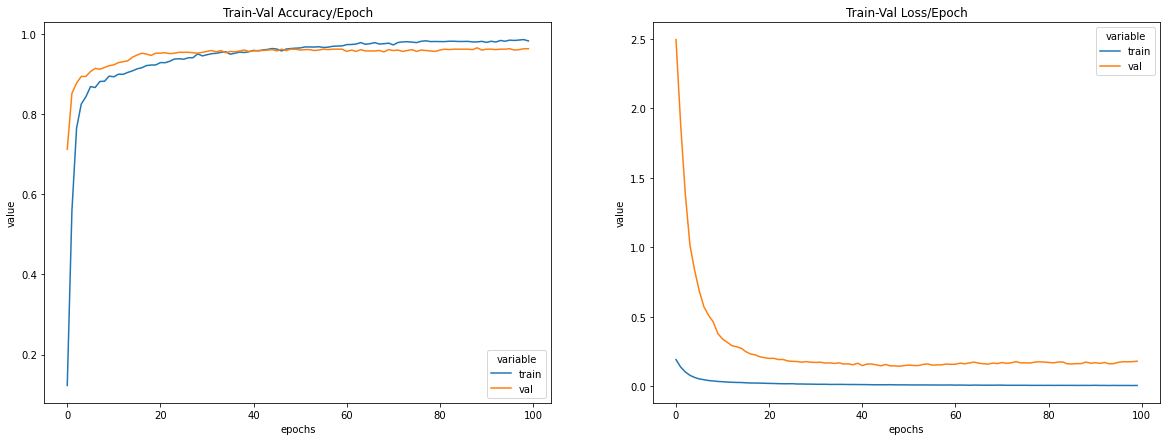

In [16]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')


In [27]:
def bag_eval(model, test_data):
    X_test=torch.FloatTensor(test_data[0]) 
    test_dataset = BagDataset(X_test, torch.from_numpy(test_data[1]).long())
    test_dataloader = DataLoader(dataset=test_dataset,
                                 batch_size=1)
    y_pred_list = []
    with torch.no_grad():
        model.eval()
        for X_batch, _ in test_dataloader:
            y_test_pred = model(X_batch)
            y_test_pred = torch.log_softmax(y_test_pred, dim = 1)
            _, y_pred_tags = torch.max(y_test_pred, dim = 1)
            y_pred_list.extend(y_pred_tags.numpy().tolist())
    
    acc = (y_pred_list== test_data[1]).sum().item()/len(test_data[1])
    print(f'Bag of Words Test Accuracy: {acc: .3f}')

bag_eval(model, [X_test_tok, y_test])

Bag of Words Test Accuracy:  0.937


# Intent Calssification with BERT

In [8]:
#preparing the datasets for BERT

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

class BertDataset(torch.utils.data.Dataset):

    def __init__(self, data):

        self.labels = np.array(data[1])
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in data[0]]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y


In [9]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 22)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, x = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        x = self.dropout(x)
        x = self.linear(x)
        x = self.relu(x)

        return x

In [10]:
def bert_train(model, train, val, learning_rate, epochs, batch_size):
    
    train = BertDataset(train)
    val = BertDataset(val)
    
    train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val, batch_size=batch_size)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)
    
    if use_cuda:
        
        model = model.cuda()
        criterion = criterion.cuda()

    for e in tqdm(range(1, epochs+1)):
        
        total_acc_train = 0
        total_loss_train = 0

        for train_input, train_label in train_dataloader:
            
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()

            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():

            for val_input, val_label in val_dataloader:

                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()

                acc = (output.argmax(dim=1) == val_label).sum().item()

                total_acc_val += acc
        loss_stats_b['train'].append(total_loss_train/len(train))
        accuracy_stats_b['train'].append(total_acc_train/len(train))
        loss_stats_b['val'].append(total_loss_val/len(val))
        accuracy_stats_b['val'].append(total_acc_val/len(val))

        print(
            f'Epochs: {e} | Train Loss: {total_loss_train / len(train): .3f} \
            | Train Accuracy: {total_acc_train / len(train): .3f} \
            | Val Loss: {total_loss_val / len(val): .3f} \
            | Val Accuracy: {total_acc_val / len(val): .3f}')



In [11]:
epochs = 10
model = BertClassifier()
LR = 1e-6


accuracy_stats_b = {
    'train': [],
    "val": [] }
loss_stats_b = {
    'train': [],
    "val": [] }

train(model, [X_tr, y_tr], [X_va, y_va], LR, epochs)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|████████████████████████████████████████████████████████████████████████████████| 896/896 [02:28<00:00,  6.01it/s]


Epochs: 1 | Train Loss:  0.421                 | Train Accuracy:  0.620                 | Val Loss:  0.238                 | Val Accuracy:  0.750


100%|████████████████████████████████████████████████████████████████████████████████| 896/896 [02:28<00:00,  6.04it/s]


Epochs: 2 | Train Loss:  0.198                 | Train Accuracy:  0.802                 | Val Loss:  0.165                 | Val Accuracy:  0.852


100%|████████████████████████████████████████████████████████████████████████████████| 896/896 [02:28<00:00,  6.04it/s]


Epochs: 3 | Train Loss:  0.143                 | Train Accuracy:  0.887                 | Val Loss:  0.124                 | Val Accuracy:  0.903


100%|████████████████████████████████████████████████████████████████████████████████| 896/896 [02:28<00:00,  6.03it/s]


Epochs: 4 | Train Loss:  0.113                 | Train Accuracy:  0.905                 | Val Loss:  0.099                 | Val Accuracy:  0.916


100%|████████████████████████████████████████████████████████████████████████████████| 896/896 [02:28<00:00,  6.03it/s]


Epochs: 5 | Train Loss:  0.095                 | Train Accuracy:  0.914                 | Val Loss:  0.084                 | Val Accuracy:  0.923


100%|████████████████████████████████████████████████████████████████████████████████| 896/896 [02:28<00:00,  6.04it/s]


Epochs: 6 | Train Loss:  0.083                 | Train Accuracy:  0.918                 | Val Loss:  0.072                 | Val Accuracy:  0.934


100%|████████████████████████████████████████████████████████████████████████████████| 896/896 [02:29<00:00,  5.99it/s]


Epochs: 7 | Train Loss:  0.076                 | Train Accuracy:  0.922                 | Val Loss:  0.067                 | Val Accuracy:  0.935


In [ ]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats_b).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats_b).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [12]:
def bert_evaluate(model, test_data):

    test = BertDataset(test_data)

    test_dataloader = DataLoader(test, batch_size=1)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test): .3f}')
    
bert_evaluate(model, [X_test,y_test])

Test Accuracy:  0.844
